# Run the simulations

In [159]:
!make tfs mc VIEW=Sch -j 3
!make tfs mc VIEW=Lay -j 3

test -d ../../work/xsch || mkdir ../../work/xsch
cd ../../work/ && make xsch LIB=JNW_GREX_SKY130A CELL=JNW_GREX
xschem -q -x -b -s -n ../design/JNW_GREX_SKY130A/JNW_GREX.sch
cp xsch/JNW_GREX.spice xsch/JNW_GREX.spice.bak
cat xsch/JNW_GREX.spice.bak | perl ../tech/script/fixsubckt > xsch/JNW_GREX.spice
rm xsch/JNW_GREX.spice.bak
perl ../../tech/script/genxdut ../../work/xsch/JNW_GREX.spice JNW_GREX
cicsim run --name Sch_tfs tran  Sch Gt "Ktt,Kss,Kff" "Tt" "Vt"
cicsim run --name Sch_mc --count 10 tran  Sch Gt "Kttmm" "Tt" "Vt"
Info: Available replacements {cic(runsim|runmeas|corner|index|testbench|rundir|sha|shas|oldsha|name|oname)}
Info: Replacing {cicname} = tran_SchGtKttTtVt
Info: Available replacements {cic(runsim|runmeas|corner|index|testbench|rundir|sha|shas|oldsha|name|oname)}
Info: Replacing {cicname} = tran_SchGtKttmmTtVt
Info: Running tran_SchGtKttmmTtVtInfo: Running tran_SchGtKttTtVt

Cmd : cd output_tran; ngspice   tran_SchGtKttTtVt.spi -r tran_SchGtKttTtVt.raw 2>&1 |tee tran

# Code for plotting curves

The code below uses a single temperature calibration at 20 C to compensate for the offset. 

In [160]:
#!/usr/bin/env python3
import yaml
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot(frun,calvector=None):
    files = list()
    with open(frun) as fi:
        for line in fi:
            if(line.startswith("*")):
                continue
            files.append(line.strip() + ".yaml")

    fig,ax = plt.subplots(nrows=2,ncols=1,sharex=True,height_ratios=[4,1],figsize=(16,9))

    for fname in files:
        with open(fname) as fi:
            obj = yaml.safe_load(fi)
        data = dict()
        vals = list()
        for k in obj:
            if("tpulse" in k):
                (dd,v) = k.split("tpulse_")
                dv = int(v)
                vals.append([dv,obj[k]])
                if(dv==20):
                    offset = obj[k]

        df = pd.DataFrame(vals, columns=['x','y'])
        df = df.sort_values(by=['x', 'y'])
        df["y"] = df["y"] - offset

        df["est"] = 0
        if(calvector is None):
            d["est"] = d["y"]
        else:
            for k in range(0,len(calvector)):
                df["est"] += np.power(df["y"],len(calvector)-k-1)*calvector[k]


        diff = df["est"] - df["x"]

        ax[0].plot(df["x"],df["est"],label=fname,marker=".",markersize=10)
        ax[1].plot(df["x"],diff)



    ax[0].set_title(frun.replace(".run",""))
    plt.xlabel("Temperature [C]")
    ax[0].set_ylabel("Estimate [C]")
    ax[1].set_ylabel("Error [C]")
    ax[0].grid()
    ax[1].grid()
    ax[0].legend(loc='upper left')
    plt.tight_layout()
    plt.savefig(frun.replace(".run",".svg"))
    plt.show()


# Typical

The gain (pulse duration back to temperature) is set only in the typical corner. I assume we can measure a single typical (or multiple) devices across temperature

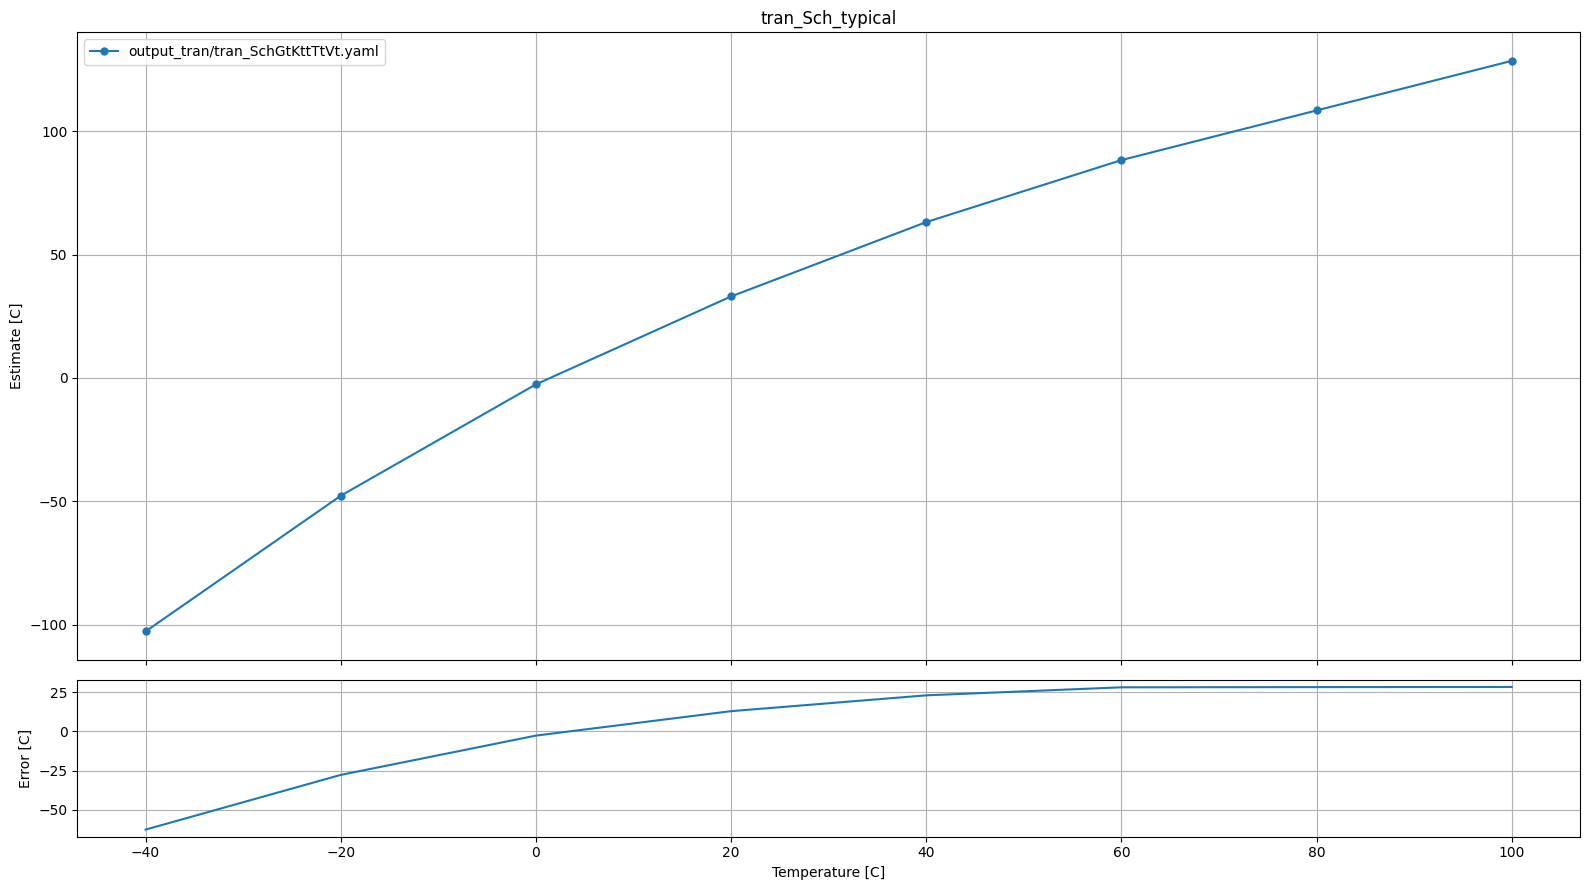

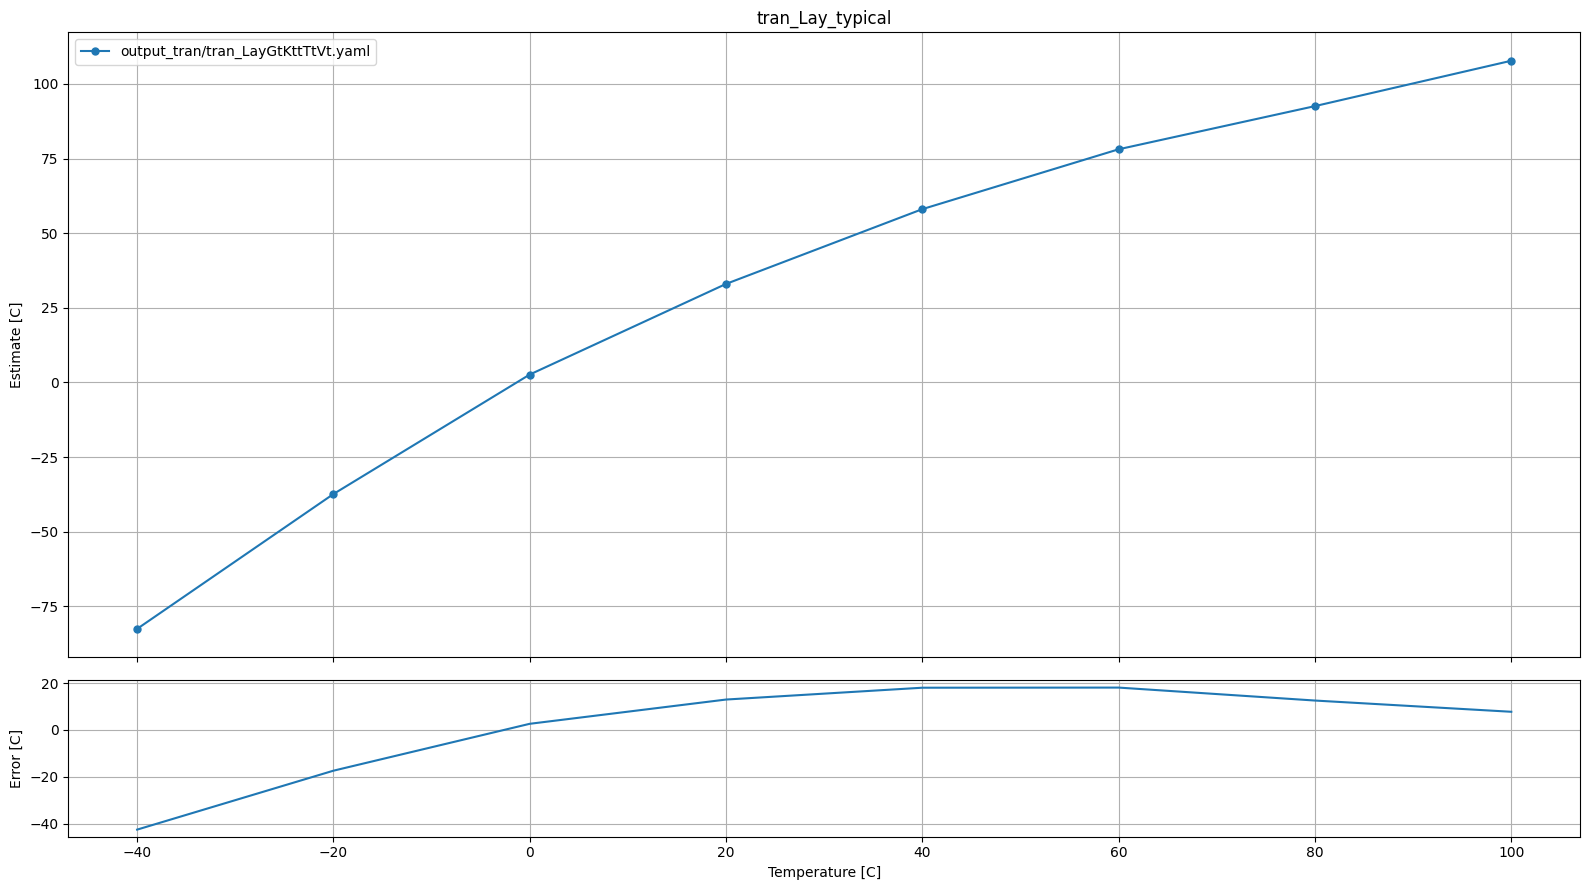

In [173]:
calvector = [-5e8,33]
plot("tran_Sch_typical.run",calvector)
plot("tran_Lay_typical.run",calvector)

# Slow/Fast

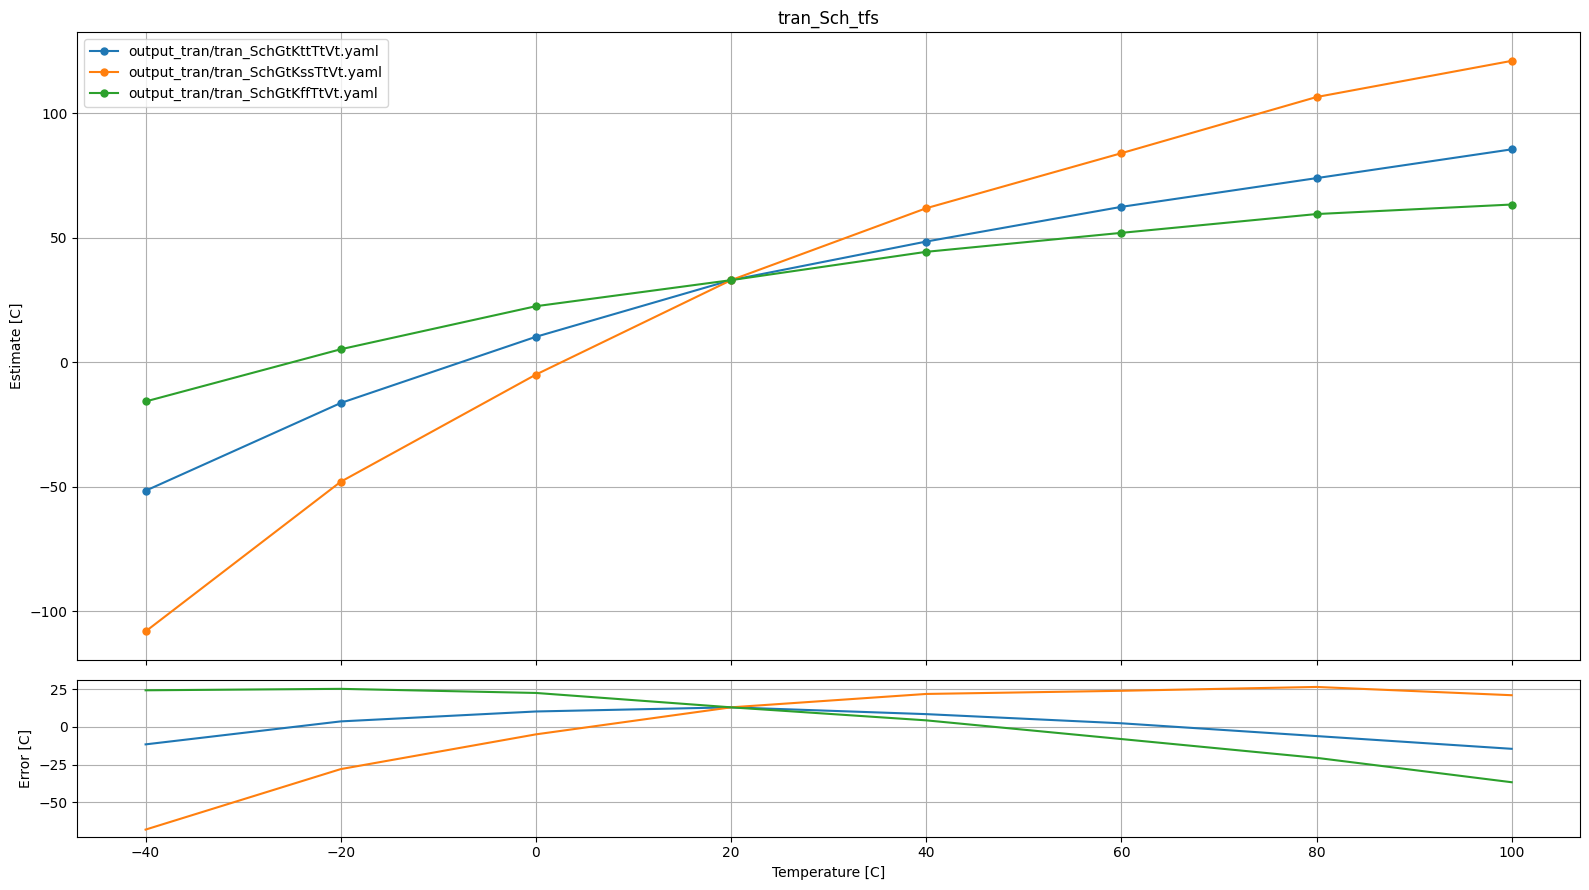

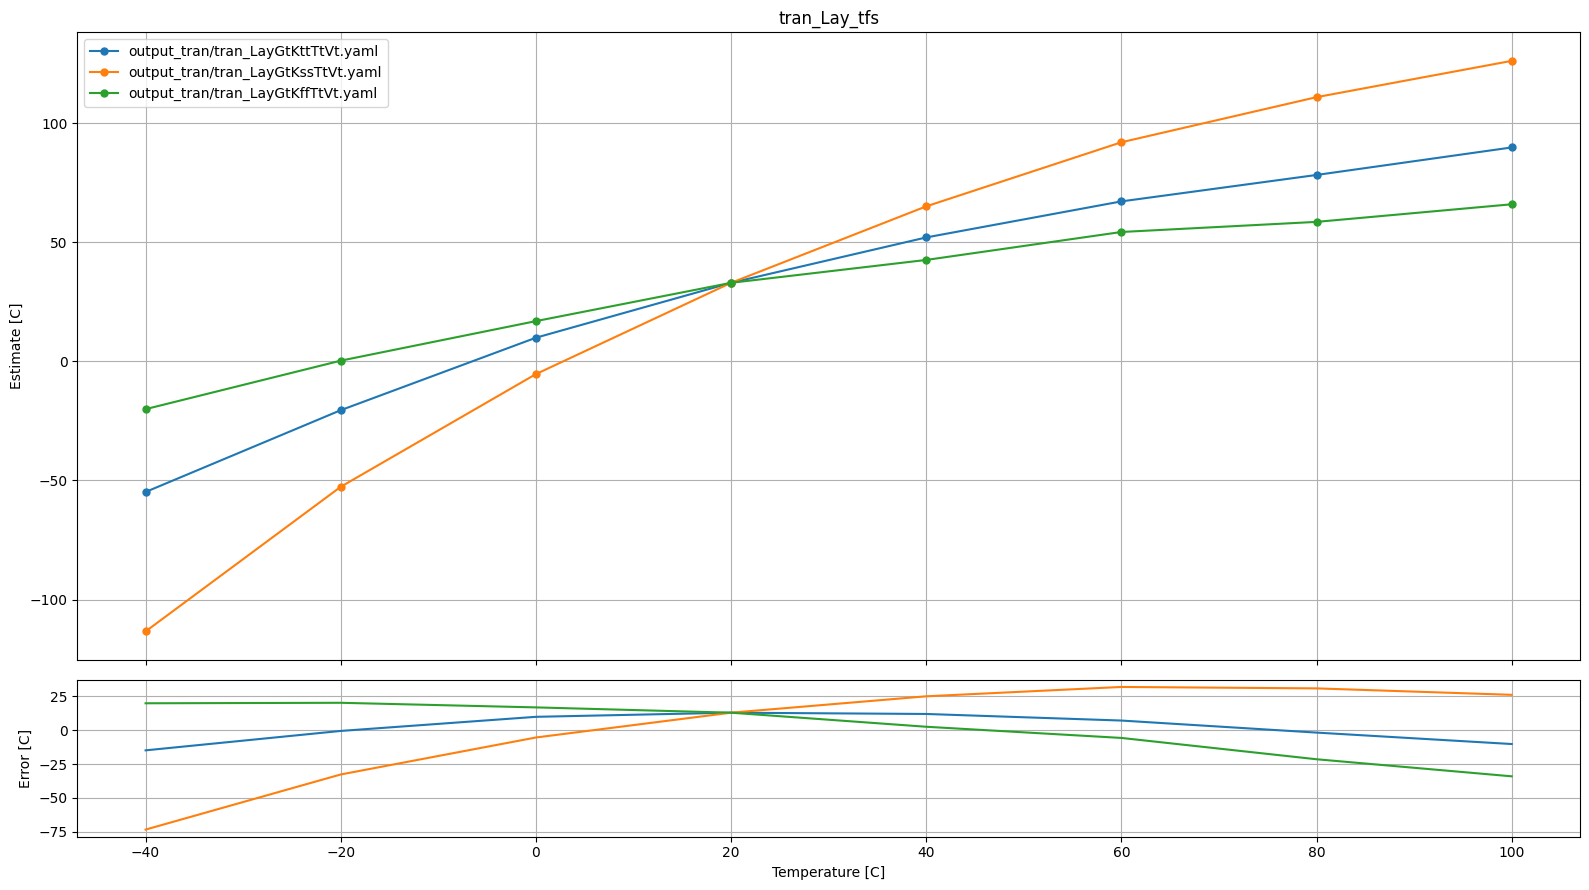

In [162]:
plot("tran_Sch_tfs.run",calvector)
plot("tran_Lay_tfs.run",calvector)

# Monte Carlo

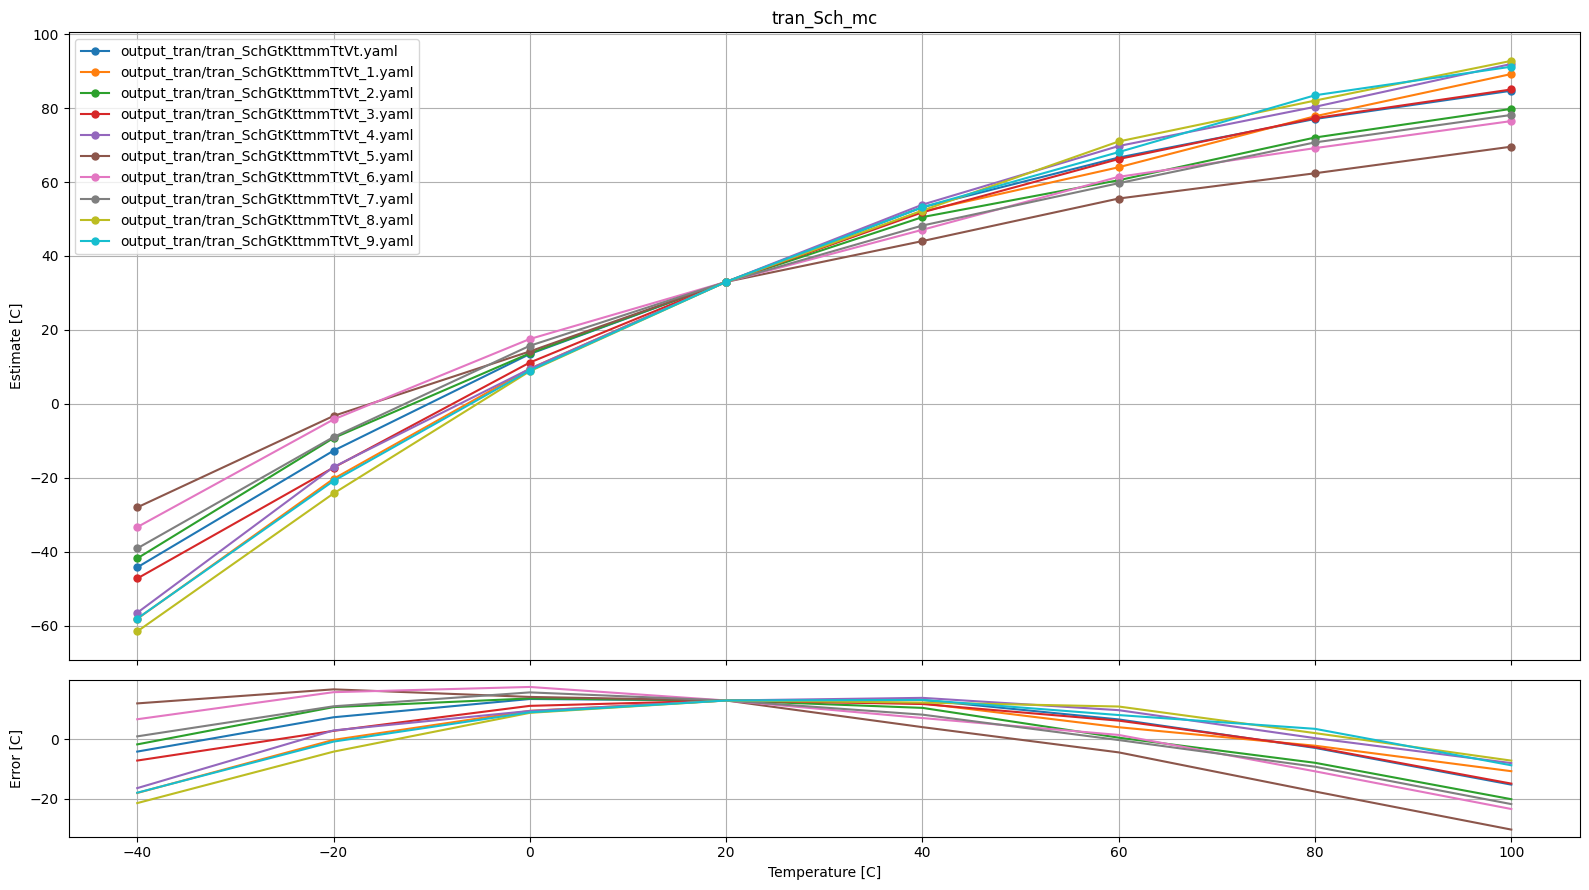

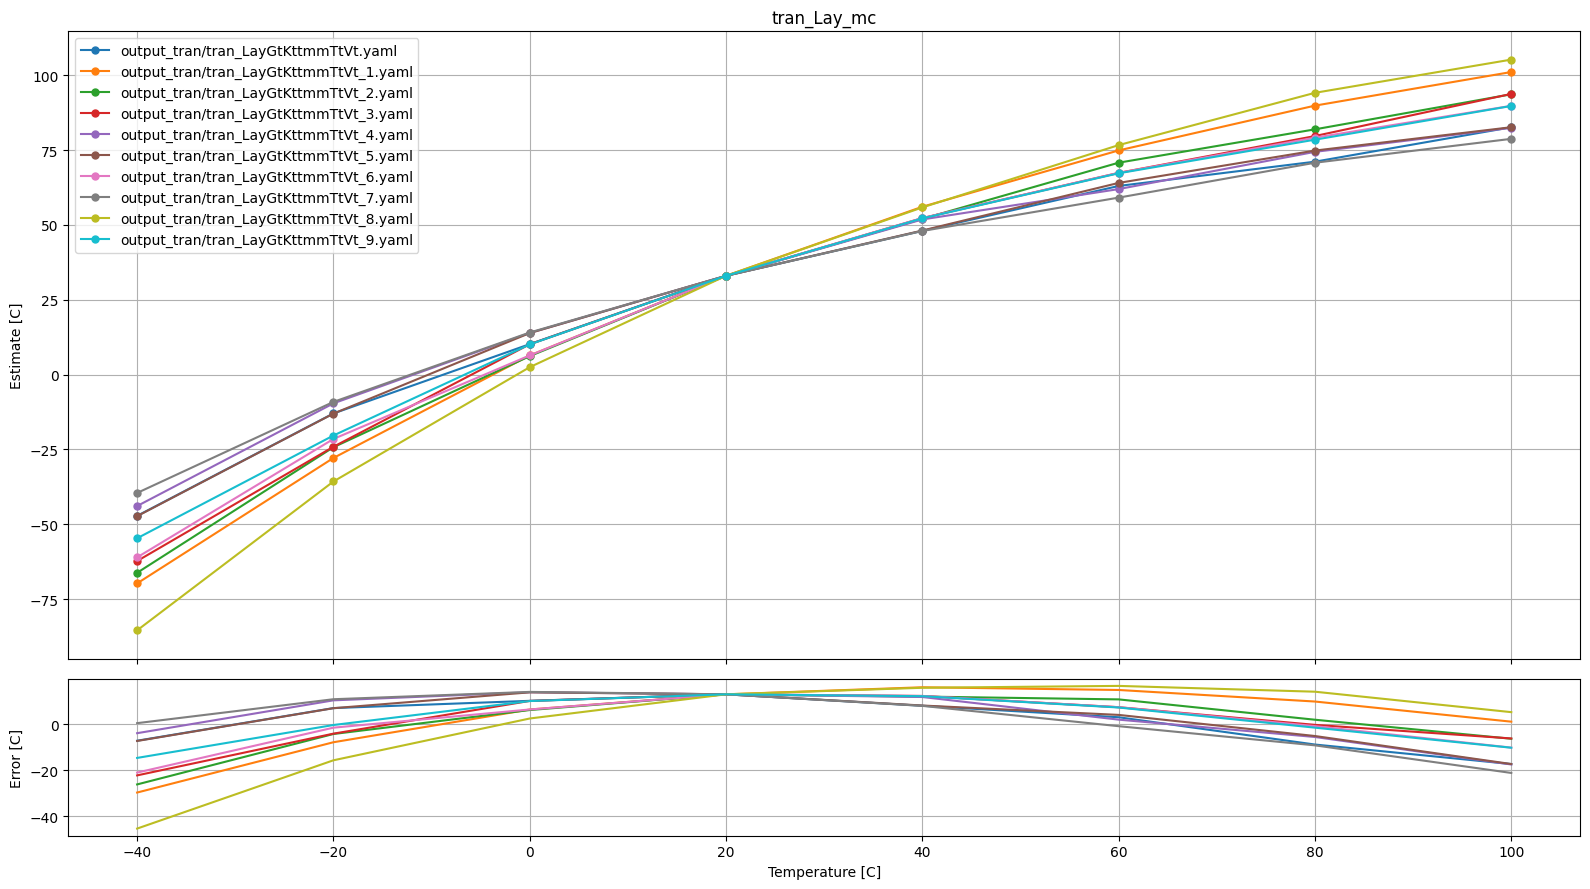

In [163]:
plot("tran_Sch_mc.run",calvector)
plot("tran_Lay_mc.run",calvector)

# Is ITD the main source of the non-linearity?

I've made an ideal model of the ITD (JNWGREX_ITD.mdl)

There is a slight difference between the non-linearity, but both has a +- 10 degrees problem, so it's likely that most of the non-linearity comes from the temperature to current conversion

In [179]:
!make typical VIEW=Mdlitd
!make typical VIEW=No


test -d ../../work/xsch || mkdir ../../work/xsch
cd ../../work/ && make xsch LIB=JNW_GREX_SKY130A CELL=JNW_GREX
xschem -q -x -b -s -n ../design/JNW_GREX_SKY130A/JNW_GREX.sch
cp xsch/JNW_GREX.spice xsch/JNW_GREX.spice.bak
cat xsch/JNW_GREX.spice.bak | perl ../tech/script/fixsubckt > xsch/JNW_GREX.spice
rm xsch/JNW_GREX.spice.bak
perl ../../tech/script/genxdut ../../work/xsch/JNW_GREX.spice JNW_GREX
cicsim run --name Mdlitd_typical tran  Mdlitd Gt Ktt Tt Vt
Info: Available replacements {cic(runsim|runmeas|corner|index|testbench|rundir|sha|shas|oldsha|name|oname)}
Info: Replacing {cicname} = tran_MdlitdGtKttTtVt
Info: Running tran_MdlitdGtKttTtVt
Cmd : cd output_tran; ngspice   tran_MdlitdGtKttTtVt.spi -r tran_MdlitdGtKttTtVt.raw 2>&1 |tee tran_MdlitdGtKttTtVt.log

******
** ngspice-43 : Circuit level simulation program
** Compiled with KLU Direct Linear Solver
** The U. C. Berkeley CAD Group
** Copyright 1985-1994, Regents of the University of California.
** Copyright 2001-2024, The ngsp

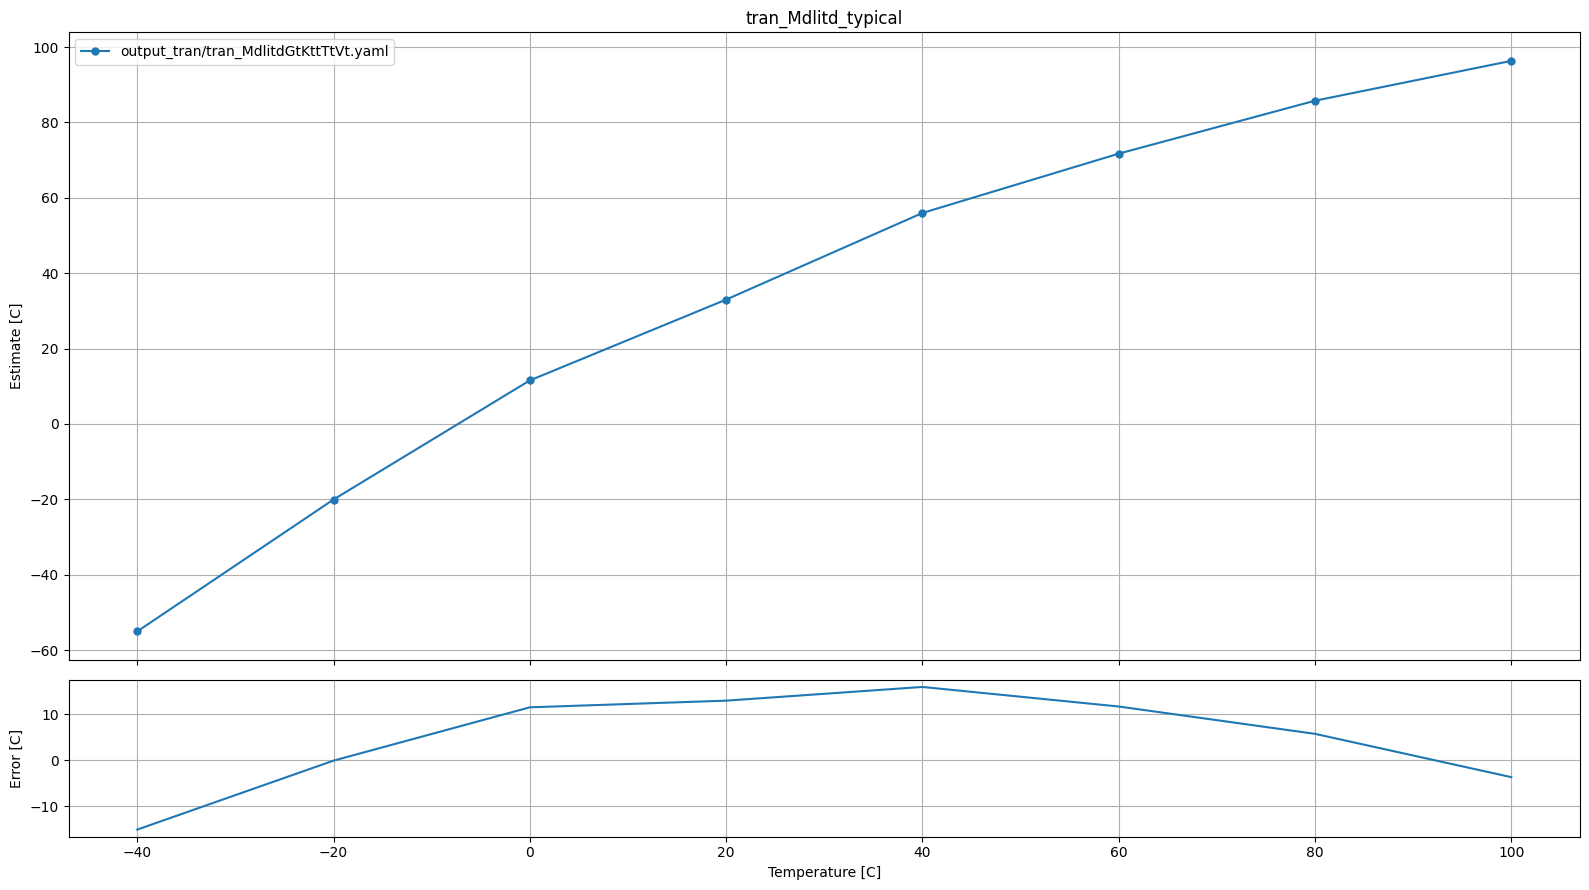

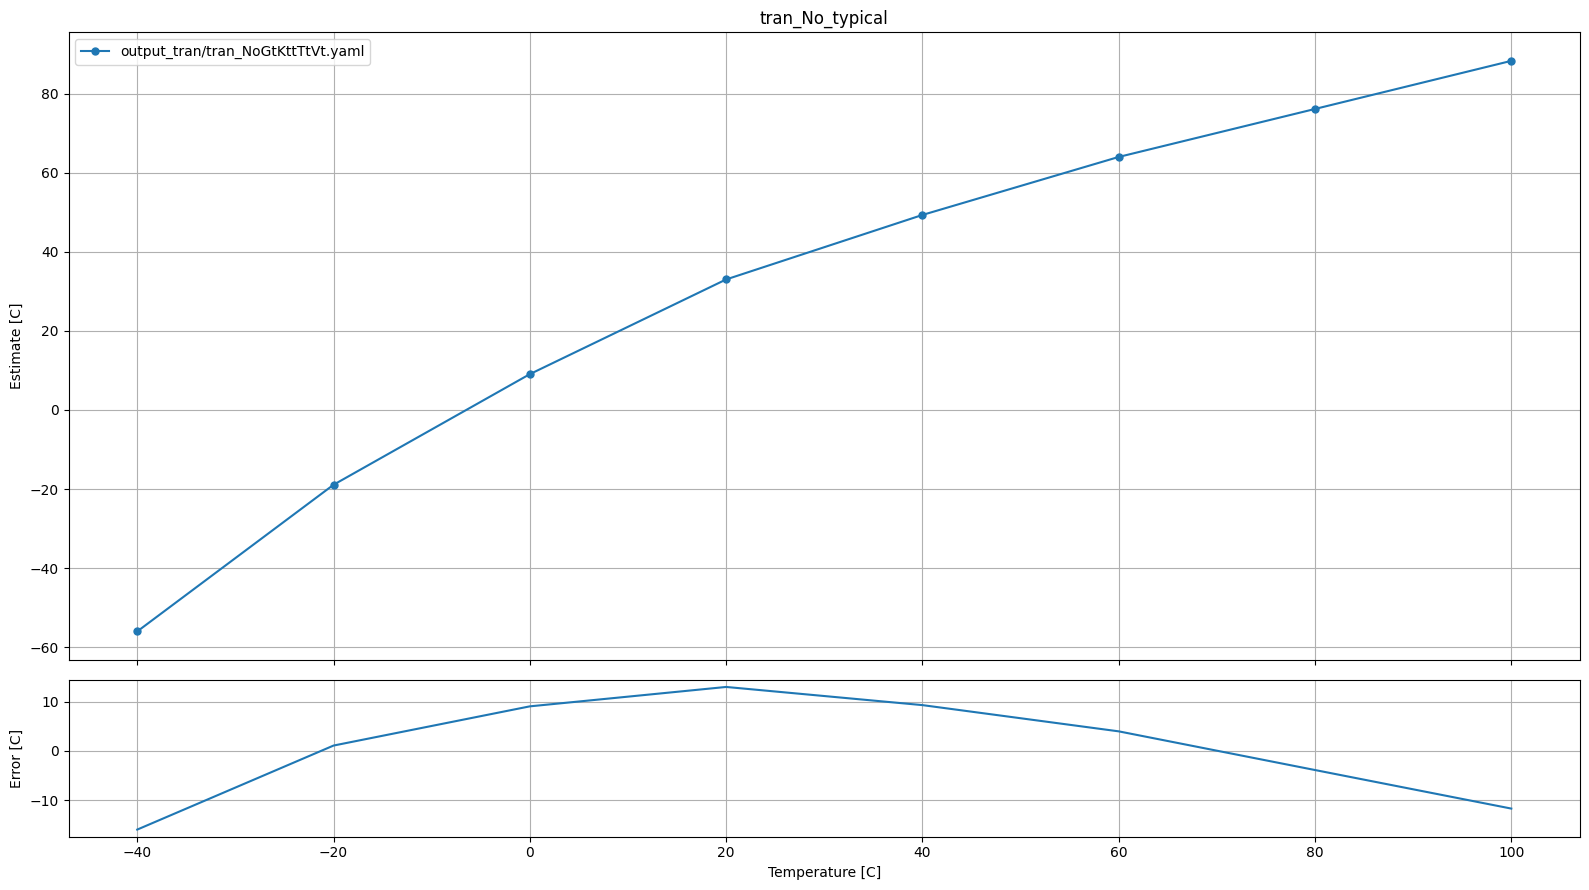

In [185]:
plot("tran_Mdlitd_typical.run",[-3.5e8,33])
plot("tran_No_typical.run",[-4e8,33])

# Is TI the main source of the non-linearity?



In [208]:
!make typical VIEW=Mdlti OPT="Mdlitd"

test -d ../../work/xsch || mkdir ../../work/xsch
cd ../../work/ && make xsch LIB=JNW_GREX_SKY130A CELL=JNW_GREX
xschem -q -x -b -s -n ../design/JNW_GREX_SKY130A/JNW_GREX.sch
cp xsch/JNW_GREX.spice xsch/JNW_GREX.spice.bak
cat xsch/JNW_GREX.spice.bak | perl ../tech/script/fixsubckt > xsch/JNW_GREX.spice
rm xsch/JNW_GREX.spice.bak
perl ../../tech/script/genxdut ../../work/xsch/JNW_GREX.spice JNW_GREX
cicsim run --name Mdlti_typical tran Mdlitd Mdlti Gt Ktt Tt Vt
Info: Available replacements {cic(runsim|runmeas|corner|index|testbench|rundir|sha|shas|oldsha|name|oname)}
Info: Replacing {cicname} = tran_MdlitdMdltiGtKttTtVt
Info: Running tran_MdlitdMdltiGtKttTtVt
Cmd : cd output_tran; ngspice   tran_MdlitdMdltiGtKttTtVt.spi -r tran_MdlitdMdltiGtKttTtVt.raw 2>&1 |tee tran_MdlitdMdltiGtKttTtVt.log

Using KLU as Direct Linear Solver
Note: Transient op started
Note: Transient op finished successfully
******
** ngspice-43 : Circuit level simulation program
** Compiled with KLU Direct Linear Solve

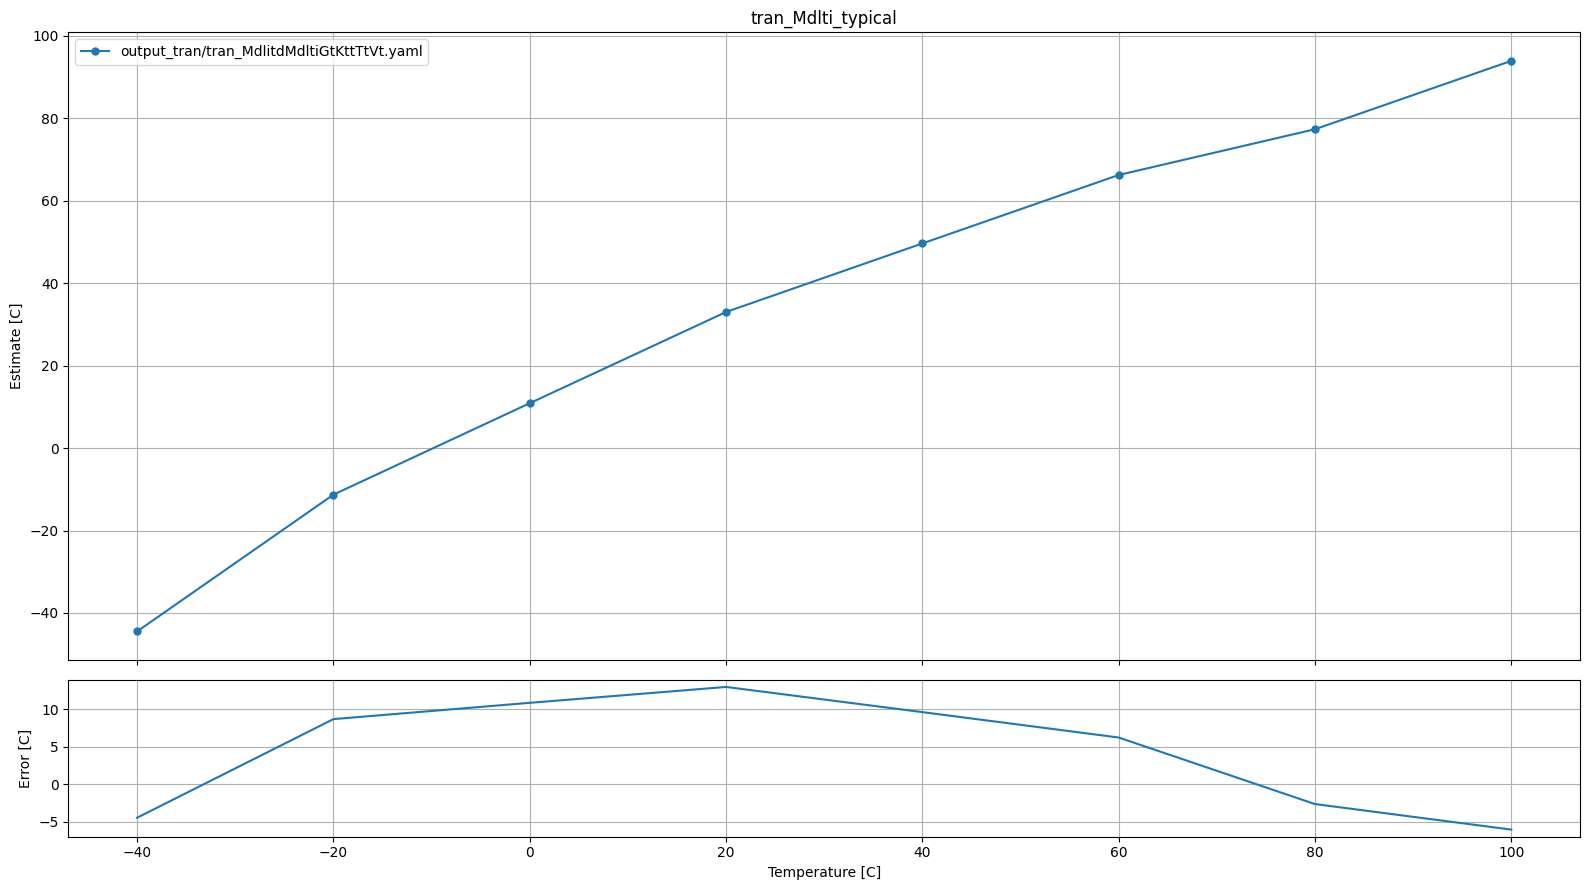

In [213]:
plot("tran_Mdlti_typical.run",[-5.5e8,33])